# Synthetic Data Comparison

In this notebook, different ways to compare the quality of augmented time series are explored.

## Imports and static variables

In [33]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from copy import deepcopy as dc
import seaborn as sns

# own classes
from utilities import load_sequential_time_series, reconstruct_sequential_data, load_complete_time_series, slice_years, train_test_split, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model, LSTMClassification
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor

In [34]:
DATA_FOLDER = Path("./data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"

In [35]:
MODEL = 'lstm'
MODE = 'classification'
MOVING_AVERAGES = [50, 20]
MA_FEATURES = [f'{ma}d MA' for ma in MOVING_AVERAGES]
FEATURES = ['Trend', 'Log Open', 'Log High', 'Log Low', 'Log Close', 'Volume', 'Daily Returns Percent', 'Intra Day Returns Percent'] + MA_FEATURES
CLASSES = ['down', 'up']

LEARNING_RATE = 0.0001 if MODEL == 'lstm' else 0.0001
FIRST_SPLIT = 0.8
SECOND_SPLIT = 0.5 
RANDOM_LABEL_PERMUTATION = False

SEQ_LEN = 7
BATCH_SIZE = 8
HIDDEN_SIZE = 4
NUM_LAYERS = 1
OUTPUT_LOGITS = True
BIDIRECTIONAL = True

NUM_EPOCHS = 1000

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading data

In [37]:
aapl = load_complete_time_series(REAL_DATA_FOLDER / "AAPL_complete.csv")

In [38]:
aapl

,Close,Open,High,Low,Adj Close,Volume,Date
0,0.128348,0.128348,0.128906,0.128348,0.099058,469033600,1980-12-12
1,0.121652,0.122210,0.122210,0.121652,0.093890,175884800,1980-12-15
2,0.112723,0.113281,0.113281,0.112723,0.086999,105728000,1980-12-16
3,0.115513,0.115513,0.116071,0.115513,0.089152,86441600,1980-12-17
4,0.118862,0.118862,0.119420,0.118862,0.091737,73449600,1980-12-18
...,...,...,...,...,...,...,...
10973,209.070007,209.149994,211.380005,208.610001,209.070007,56713900,2024-06-25
10974,213.250000,211.500000,214.860001,210.639999,213.250000,66213200,2024-06-26
10975,214.100006,214.690002,215.740005,212.350006,214.100006,49772700,2024-06-27
10976,210.619995,215.770004,216.070007,210.300003,210.619995,82542700,2024-06-28


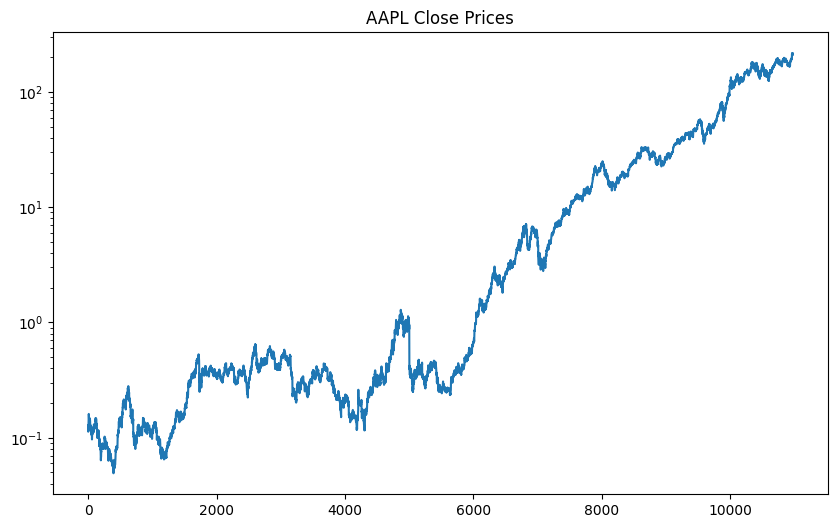

In [39]:
# plot log of close prices
plt.figure(figsize=(10, 6))
plt.plot(aapl['Close'])
plt.yscale('log')
plt.title('AAPL Close Prices')
plt.show()

## Feature Selection

In [40]:
# get normal difference
# aapl['Daily Returns'] = aapl['Close'].diff()

# get percaentage difference
aapl['Daily Returns Percent'] = aapl['Close'].pct_change()

In [41]:
aapl['Intra Day Returns Percent'] = ((aapl['Close'] - aapl['Open']) / aapl['Open']) * 100

In [42]:
# get log values
aapl['Log Close'] = np.log(aapl['Close'])
aapl['Log Open'] = np.log(aapl['Open'])
aapl['Log High'] = np.log(aapl['High'])
aapl['Log Low'] = np.log(aapl['Low'])

In [43]:
# Create moving averages
for ma in MOVING_AVERAGES:
    aapl[f'{ma}d MA'] = aapl['Close'].rolling(window=ma).mean()

In [44]:
# set trend to 1 if daily return > 1, else -1
aapl['Trend'] = aapl['Daily Returns Percent'].apply(lambda x: 1 if x > 0 else 0)

In [45]:
aapl = aapl.dropna()
aapl = aapl[FEATURES]

In [46]:
aapl.head(25)

,Trend,Log Close,Volume,Daily Returns Percent,40d MA
39,0,-2.106591,16755200,-0.052171,0.137054
40,0,-2.106591,18345600,0.000000,0.136886
41,0,-2.139226,13843200,-0.032108,0.136789
42,0,-2.148757,14560000,-0.009487,0.136886
43,0,-2.172970,11155200,-0.023922,0.136844
44,1,-2.148757,12275200,0.024508,0.136788
45,1,-2.106591,19241600,0.043068,0.136677
46,0,-2.168080,22310400,-0.059637,0.136230
47,0,-2.223229,24371200,-0.053655,0.135491
48,1,-2.207884,14112000,0.015463,0.134612


## Preprocessing

In [47]:
aapl_np = aapl.to_numpy()

In [48]:
aapl_train, aapl_test = train_test_split(aapl_np, FIRST_SPLIT)
aapl_test, aapl_val = train_test_split(aapl_test, SECOND_SPLIT)

In [49]:
# account for moving averages
aapl_test = aapl_test[max(MOVING_AVERAGES):]
aapl_val = aapl_val[max(MOVING_AVERAGES):]

In [50]:
scaler = Scaler(aapl_train, scale_features_individually=False)

In [51]:
aapl_train_scaled = scaler.scale_data(aapl_train)
aapl_test_scaled = scaler.scale_data(aapl_test)
aapl_val_scaled = scaler.scale_data(aapl_val)

In [52]:
aapl_train_seq_scaled = split_data_into_sequences(aapl_train_scaled, SEQ_LEN)
aapl_test_seq_scaled = split_data_into_sequences(aapl_test_scaled, SEQ_LEN)
aapl_val_seq_scaled = split_data_into_sequences(aapl_val_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (8745, 7, 5)
Shape of the data after splitting into sequences: (1048, 7, 5)
Shape of the data after splitting into sequences: (1048, 7, 5)


In [53]:
criterion = nn.BCEWithLogitsLoss()

In [54]:
def create_data_loader(X_train, y_train, X_test, y_test, X_val, y_val):
    # get baseline performance
    train_dataset = TimeSeriesDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = TimeSeriesDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    val_dataset = TimeSeriesDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader, val_loader

In [55]:
def train_model_once(no_features, train_loader, val_loader):
    # create and train model
    model = LSTMClassification(
        device=device,
        batch_size = BATCH_SIZE,
        input_size=no_features,
        hidden_size=HIDDEN_SIZE,
        num_stacked_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        output_logits=OUTPUT_LOGITS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    _, _, _, _, model = train_model(model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                device=device,
                verbose=False)
    
    return model

In [56]:
def get_test_performance(model, X_test, y_test):
    with torch.inference_mode(): 
        test_logits = model(X_test.to(device)) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

        test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
        test_loss = criterion(test_logits, y_test).item()

    return test_acc, test_loss

In [57]:
# get train, test and validation data
X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(aapl_train_seq_scaled, aapl_test_seq_scaled, aapl_val_seq_scaled)

In [58]:
results = pd.DataFrame(columns=['Feature', 'Metric', 'Value'])

# get baseline performance
train_loader, test_loader, val_loader = create_data_loader(X_train, y_train, X_test, y_test, X_val, y_val)
trained_model = train_model_once(len(FEATURES)-1, train_loader, val_loader)
test_acc, test_loss = get_test_performance(trained_model, X_test, y_test)

# save baseline performance
results = pd.concat([results, pd.DataFrame([{'Feature': 'baseline', 'Metric': 'Accuracy', 'Value': test_acc}])], ignore_index=True)
results = pd.concat([results, pd.DataFrame([{'Feature': 'baseline', 'Metric': 'Loss', 'Value': test_loss}])], ignore_index=True)

for feature in FEATURES[1:]:

    print(f'Current feature: {feature}')

    # random permutation of one specific feature
    feature_index = FEATURES.index(feature)-1 # -1 because of the trend feature
    permuted_X_test = dc(X_test)
    permuted_X_test[:, :, feature_index] = torch.tensor(np.random.permutation(permuted_X_test[:, :, feature_index]), dtype=torch.float32)

    train_loader, test_loader, val_loader = create_data_loader(X_train, y_train, permuted_X_test, y_test, X_val, y_val)
    trained_model = train_model_once(len(FEATURES)-1, train_loader, val_loader)
    test_acc, test_loss = get_test_performance(trained_model, permuted_X_test, y_test)

    # save performance
    results = pd.concat([results, pd.DataFrame([{'Feature': feature, 'Metric': 'Accuracy', 'Value': test_acc}])], ignore_index=True)
    results = pd.concat([results, pd.DataFrame([{'Feature': feature, 'Metric': 'Loss', 'Value': test_loss}])], ignore_index=True)

/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_11873/3543369078.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_11873/4170370861.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Feature': 'baseline', 'Metric': 'Accuracy', 'Value': test_acc}])], ignore_index=True)


Current feature: Log Close
Current feature: Volume
Current feature: Daily Returns Percent
Current feature: 40d MA


In [59]:
results

,Feature,Metric,Value
0,baseline,Accuracy,54.007634
1,baseline,Loss,0.690832
2,Log Close,Accuracy,54.007634
3,Log Close,Loss,0.690012
4,Volume,Accuracy,52.480916
5,Volume,Loss,0.692480
6,Daily Returns Percent,Accuracy,54.007634
7,Daily Returns Percent,Loss,0.690423
8,40d MA,Accuracy,54.007634
9,40d MA,Loss,0.689656


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_11873/1055829485.py:37: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax1.legend(bars, labels, loc='upper left')


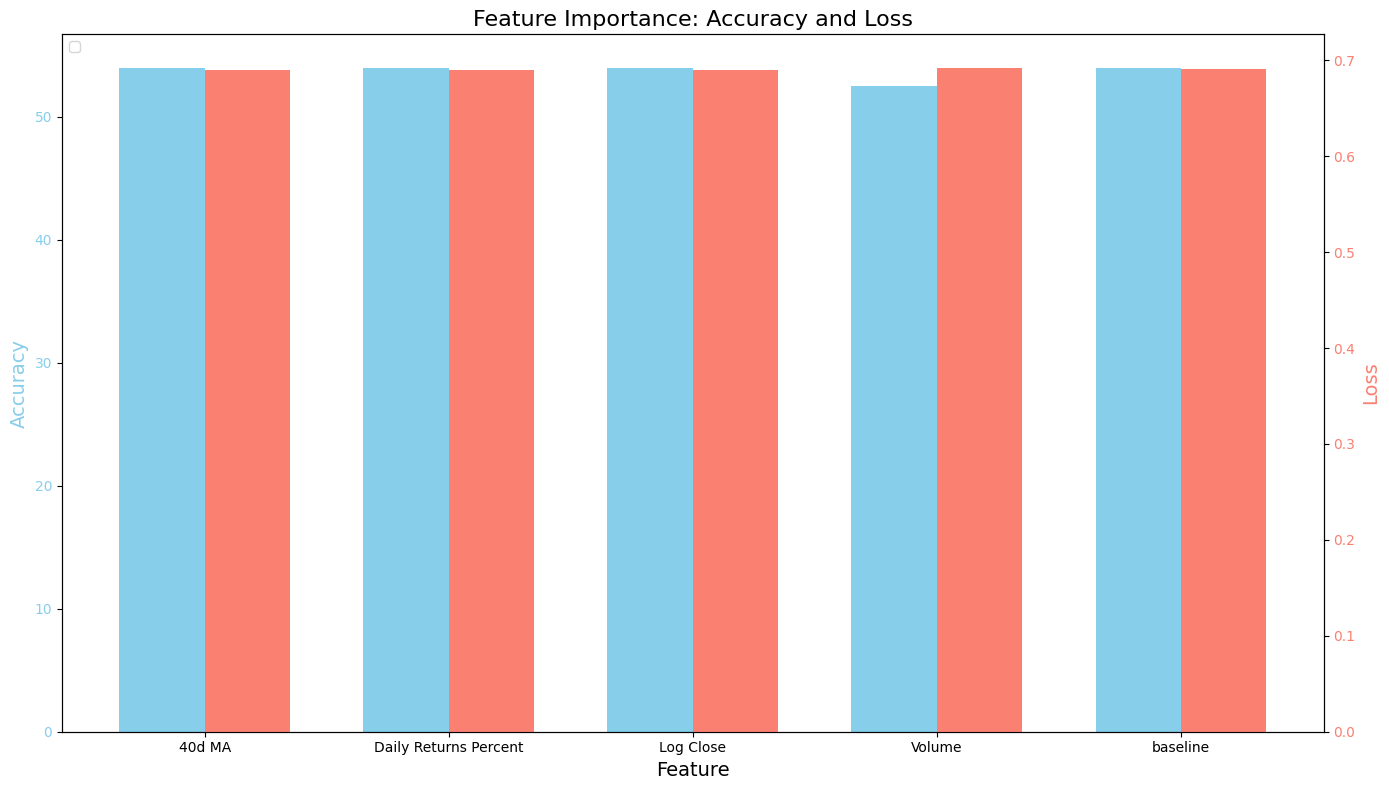

In [60]:
# Erstelle eine Pivot-Tabelle, um die Daten besser zu handhaben
pivot_df = results.pivot(index='Feature', columns='Metric', values='Value')

# Initialisiere die Hauptfigur und die Hauptachse
fig, ax1 = plt.subplots(figsize=(14, 8))

# Balkenbreite
bar_width = 0.35

# Positionen der Balken
r1 = np.arange(len(pivot_df.index))
r2 = [x + bar_width for x in r1]

# Balken für Accuracy
accuracy_bars = ax1.bar(r1, pivot_df['Accuracy'], color='skyblue', width=bar_width, label='Accuracy')

# Zweite y-Achse für Loss
ax2 = ax1.twinx()
loss_bars = ax2.bar(r2, pivot_df['Loss'], color='salmon', width=bar_width, label='Loss')

# Titel und Achsenbeschriftungen hinzufügen
ax1.set_title('Feature Importance: Accuracy and Loss', fontsize=16)
ax1.set_xlabel('Feature', fontsize=14)
ax1.set_ylabel('Accuracy', fontsize=14, color='skyblue')
ax2.set_ylabel('Loss', fontsize=14, color='salmon')

# x-Achse rotieren für bessere Lesbarkeit und x-Ticks setzen
plt.xticks([r + bar_width/2 for r in range(len(pivot_df.index))], pivot_df.index, rotation=90)

# Achsenbeschriftungen einfärben
ax1.tick_params(axis='y', labelcolor='skyblue')
ax2.tick_params(axis='y', labelcolor='salmon')

# Legenden kombinieren
bars = accuracy_bars + loss_bars
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc='upper left')

# Diagramm anzeigen
plt.tight_layout()
plt.show()